### 0. Import libraries

In [1]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn.utils.rnn import pad_sequence

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger,CSVLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.tensorboard import SummaryWriter

# pytorch model summary 
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

# save data values 
import pickle

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem

from sandiapv_energy_prediction import *
import optuna


C:\Users\denni\AppData\Local\Temp\ipykernel_19944\777256687.py:23: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Define model

In [246]:
class EnergyPredictionModel(nn.Module):
    """ Energy Prediction Model """
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size,fc_size, dropout_rate=0.1,dataset_values= None):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_rnn1 = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        #self.dynamic_rnn2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        # Increased depth in fully connected layers
        self.fc1 = nn.Linear(hidden_size + static_feature_size, 2*fc_size)  
        self.fc2 = nn.Linear(2*fc_size, fc_size)
        self.fc3 = nn.Linear(fc_size, 24)
        
        self.gelu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid() 

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)

        # Load dataset values
        self.dynamic_cols = dynamic_feature_size

        # values for inference
        self.mean = dataset_values['mean']
        self.std = dataset_values['std']
        self.min = dataset_values['output_mins']
        self.max = dataset_values['output_maxs']
            
    def forward(self, dynamic_features, static_features):
        """ Forward pass of the model """
        # Two or one lstm layer
        output,(h_n,_)  = self.dynamic_rnn1(dynamic_features)
        #output, (h_n, _) = self.dynamic_rnn2(output)
        h_n = h_n.squeeze(0)
        
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
        x = self.fc1(concatenated_features)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        # Sigmoid activation function for values between 0-1 
        output =  self.sigmoid(x)
        
        return output
    
    def predict(self, x_dynamic, x_static):
        """ Perform inference on a single sample"""
        # Get the number of static features
        static_dim = x_static.shape[1] -1
        
        # Ensure x_static and x_dynamic are torch tensors and are of correct type
        x_static = torch.tensor(x_static, dtype=torch.float32)
        x_dynamic = torch.tensor(x_dynamic, dtype=torch.float32)
        
        # Normalize static features
        static_mean = torch.tensor(self.mean[:static_dim] + [0], dtype=torch.float32)
        static_std = torch.tensor(self.std[:static_dim] + [1], dtype=torch.float32)
        x_static_norm = (x_static - static_mean) / static_std
        
        # Normalize dynamic features
        dynamic_mean = torch.tensor(self.mean[static_dim:], dtype=torch.float32).reshape(1, -1)
        dynamic_std = torch.tensor(self.std[static_dim:], dtype=torch.float32).reshape(1, -1)
        x_dynamic_norm = (x_dynamic - dynamic_mean) / dynamic_std

        # Switch model to evaluation mode
        self.eval()

        # Perform inference
        with torch.no_grad():
            normalized_output = self.forward(x_dynamic_norm, x_static_norm)

        # Denormalize the output if needed
        denormalized_output = normalized_output * (self.max - self.min) + self.min
        return denormalized_output

## 2. Define training class


In [247]:
class TrainEnergyPrediction(pl.LightningModule):
    """ Training Class for Energy Prediction Model """	
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size,fc_size, learning_rate, loss_type='mse',dataset_values= None):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()

        # Initialize model
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size,fc_size, dropout_rate=0.1,dataset_values= dataset_values)

        # Initialize loss function
        if loss_type == 'mse':
            self.loss_fn = nn.MSELoss(reduction='sum')
        elif loss_type == 'l1':
            self.loss_fn = nn.L1Loss(reduction='sum')
        elif loss_type == 'huber':
            self.loss_fn = nn.HuberLoss(reduction='sum', delta=1.0)
        else:
            raise ValueError("Unsupported loss type. Choose from 'mse', 'l1', 'huber'.")

        # Initialize lists to store losses and evaluation metrics
        self.train_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.train_auc = []
        self.validation_auc = []
        self.train_mape = []
        self.val_mape = []

        # Save learning rate
        self.learning_rate = learning_rate
        
    def forward(self, x_dynamic, x_static):
        """" Forward pass of the model """
        return self.model(x_dynamic, x_static)

    def training_step(self, batch, batch_idx):
        """ Training step 

        Parameters:
        batch : tuple
            A tuple containing the dynamic features, static features, and target values.
        batch_idx : int
            The index of the batch.
        
        Returns: 
        train_loss : float
            The total loss for the training step."""	
        
        # Get the batch
        x_dynamic, x_static, y_true = batch

        # Perform forward pass
        y_pred = self(x_dynamic, x_static)
 
        # Calculate loss
        train_loss = self.loss_fn(y_pred, y_true)
        self.train_losses.append(train_loss.item())
        
        # Calculate L1 loss
        sum_loss = nn.L1Loss(reduction='sum')(y_pred, y_true)
            
        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0
        self.train_auc.append(auc_ratio.item())

        # Calculate MAPE score
        mape = self.calculate_mape(y_true, y_pred)
        self.train_mape.append(mape.item())

        # Log metrics   
        self.log('train_auc', auc_ratio, on_step=True, on_epoch=True, logger=True)
        self.log('train_loss', train_loss, on_step=True, on_epoch=True,  logger=True)
        self.log('train_l1_sum', sum_loss, on_step=False, on_epoch=True,  logger=True)
        self.log('train_mape_score', mape, on_step=True, on_epoch=True)
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        """ Validation step 
        
        parameters:
        batch : tuple
            A tuple containing the dynamic features, static features, and target values.
        batch_idx : int
            The index of the batch.
        
        Returns:
        val_eval_metric : float
            The evaluation metric for the validation step. """
        
        # Get the batch
        x_dynamic, x_static, y_true = batch
        
        # Perform forward pass
        y_pred = self(x_dynamic, x_static)

        # Calculate loss
        val_loss = self.loss_fn(y_pred, y_true)
        self.validation_losses.append(val_loss.item()) 
        
        # Calculate L1 loss
        val_eval_metric = nn.L1Loss(reduction='mean')(y_pred, y_true)
        
        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0
        self.validation_auc.append(auc_ratio.item())

        # Calculate MAPE score
        mape = self.calculate_mape(y_true, y_pred)
        self.val_mape.append(mape.item())

        # Log metrics
        self.log('validation_auc', auc_ratio, on_step=True, on_epoch=True, logger=True)
        self.log('val_train_loss', val_loss, on_step=False, on_epoch=True, logger=True)
        self.log('val_evaluation_metric', val_eval_metric, on_step=False, on_epoch=True,  logger=True) 
        self.log('val_mape_score', mape, on_step=True, on_epoch=True)

        return val_eval_metric
    
    def test_step(self, batch, batch_idx, dataloader_idx=0):
        """ Test step 

        Parameters:
        batch : tuple
            A tuple containing the dynamic features, static features, and target values.
        batch_idx : int
            The index of the batch.
        dataloader_idx : int
            The index of the dataloader.

        Returns:
        test_loss : float
            The total loss for the test step."""
        
        # Get the batch
        x_dynamic, x_static, y_true = batch

        # Perform forward pass
        y_pred = self(x_dynamic, x_static)

        # Calculate loss
        test_loss = self.loss_fn(y_pred, y_true)

        # Calculate L1 loss
        sum_loss = nn.L1Loss(reduction='sum')(y_pred, y_true)
        
        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0

        # Calculate MAPE score
        mape = self.calculate_mape(y_true, y_pred)

        # Log metrics
        self.log(f'Total test_loss', test_loss)
        self.log(f'Total L1 loss', sum_loss)
        self.log(f'Total auc_ratio', auc_ratio)
        self.log('test_mape_score', mape)
        self.test_losses.append(test_loss.item())
        
        return {
            'test_loss': test_loss,
            'sum_l1_loss': sum_loss,
            'auc_ratio': auc_ratio,
            'test_mape_score': mape,
        }

    def configure_optimizers(self):
        """ Configure optimizer """	
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer
    
    def calculate_auc(self, y_values):
        """ Calculate AUC 
        
        Parameters:
        y_values : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Estimated target values from the model.
        
        Returns:
        auc : float
            The area under the curve (AUC) 
        """
        	
        y_values = y_values.detach().numpy()
        auc = np.trapz(y_values, axis=1)
        return np.mean(auc)

    def calculate_mape(self, y_true, y_pred):
        """ Calculate MAPE 
        
        Parameters:
        y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Ground truth (correct) target values.
        y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Estimated target values from the model.
        
        Returns:
        mape : float
            The mean absolute percentage error (MAPE) score. A lower MAPE indicates better performance."""
        
        # Filter out zero values
        y_true_filtered = y_true +0.1 # FOR NUMERICAL STABILITY
        y_pred_filtered = y_pred +0.1 # FOR NUMERICAL STABILITY

        # Calculate MAPE
        mape = torch.mean(torch.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
        return mape
    
    def calculate_rmse(self, y_true, y_pred):
        """ Calculate RMSE 
        
        Parameters:
        y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Ground truth (correct) target values.
        y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Estimated target values from the model.

        Returns:
        rmse : float
            The root mean squared error (RMSE) score. A lower RMSE indicates better performance.    
        """
        mse = nn.MSELoss(reduction='mean')(y_pred, y_true)
        rmse = torch.sqrt(mse)
        return rmse

    

    def r2_score(y_true, y_pred):
        """
        Calculate the R-squared score, a measure of how well the model predictions approximate the true values.
        
        Parameters:
        y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Ground truth (correct) target values.
        y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Estimated target values from the model.

        Returns:
        r_squared : float
            The R-squared score. A value of 1 indicates perfect prediction, 
            and a value of 0 indicates that the model performs as well as a model 
            that always predicts the mean of the target values, regardless of the input features.
        """
        # Calculate the residual sum of squares
        ss_res = ((y_true - y_pred) ** 2).sum()
        # Calculate the total sum of squares
        ss_tot = ((y_true - y_true.mean()) ** 2).sum()
        # Calculate the R-squared score
        r_squared = 1 - (ss_res / ss_tot)
        return r_squared


<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [248]:
CONVERTER = {
    'temperature_sequence': ast.literal_eval, 
    'wind_speed_sequence': ast.literal_eval, 
    'dni_sequence': ast.literal_eval, 
    'dhi_sequence': ast.literal_eval, 
    'global_irradiance_sequence': ast.literal_eval,
    'energy_data': ast.literal_eval,
}

class SolarPanelDataset(Dataset):
    """ Solar Panel Dataset

    Returns:
    dynamic_features : torch.tensor
        The dynamic features for the model.
    static_features : torch.tensor
        The static features for the model.
    outputs : torch.tensor
        The target values for the model."""	

    def __init__(self, synthetic_csv, measurement_csv, transform=None, sequence_length=24):
        """ Initialize the SolarPanelDataset class
         
        Parameters:
        synthetic_csv : str
            The path to the synthetic data CSV file.
        measurement_csv : str
            The path to the measurement data CSV file.
        transform : callable, optional
            A function/transform to apply to the data.
        sequence_length : int, optional
            The length of the sequences. """	
        
        # Save sequence length
        self.sequence_length = sequence_length

        # Initialize mean and std lists
        self.mean = []
        self.std =[]

        # Initialize dynamic and static columns
        self.dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        self.static_cols = ['tilt', 'azimuth','module_type']   
        self.features = self.dynamic_cols + self.static_cols 
        
        # Load data from both CSVs
        self.synthetic_data = pd.read_csv(synthetic_csv, converters=CONVERTER)  
        self.measurement_data = pd.read_csv(measurement_csv, converters=CONVERTER) 
        
        # Optionally apply transformations/pre-processing
        self.transform = transform
        
        # Combine data for easy shuffling and splitting
        self.synthetic_data['data_type'] = 'synthetic'
        self.measurement_data['data_type'] = 'measurement'
        self.data_frame = pd.concat([self.synthetic_data, self.measurement_data], ignore_index=True)
        
        # Encode string to int
        self.data_frame['module_type'] = LabelEncoder().fit_transform(self.data_frame['module_type'])
        
        # Ensure all sequences are of the same length
        self.pad_or_truncate_sequences()

        # Normalize features and outputs
        self.normalize_features()
        self.normalize_outputs()

    def pad_or_truncate_sequences(self):
        """Ensure all sequences are of the same length by padding or truncating them."""
        dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        for col in dynamic_cols:
            self.data_frame[col] = self.data_frame[col].apply(self.pad_or_truncate)

    def pad_or_truncate(self, sequence):
        """Pad or truncate a sequence to the desired length."""

        # Pad or truncate sequence
        if len(sequence) > self.sequence_length:
            return sequence[:self.sequence_length]
        # Pad sequence with zeros
        elif len(sequence) < self.sequence_length:
            return sequence + [0.0] * (self.sequence_length - len(sequence))
        return sequence

    def denormalize_output(self, normalized_output):
        """ Denormalize the output using min-max scaling."""
        denormalized_output = normalized_output * (self.output_maxs - self.output_mins) + self.output_mins
        return denormalized_output
    
    def normalize_features(self):
        """Normalize features"""

        # Normalizing static features
        for feature in self.static_cols:
            mean = self.data_frame[feature].mean()
            self.mean.append(mean)
            std = self.data_frame[feature].std()
            self.std.append(std)
            if std > 0:
                self.data_frame[feature] = (self.data_frame[feature] - mean) / std
            else:
                self.data_frame[feature] = 0  

        # Normalizing dynamic features
        for col in self.dynamic_cols:
            col_data = np.concatenate(self.data_frame[col].values)
            mean = col_data.mean()
            self.mean.append(mean)
            std = col_data.std()
            self.std.append(std)
            if std > 0:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: (np.array(x) - mean) / std)
            else:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: np.zeros_like(x))  

    def normalize_outputs(self):
        """ Normalize outputs using min-max scaling."""

        # retrieve energy_data
        energy_array = np.array(self.data_frame['energy_data'].tolist())

        # Save min and max values for denormalization
        self.output_mins = energy_array.min(axis=0)
        self.output_maxs = energy_array.max(axis=0)

        # Avoid division by zero in case max == min
        range = self.output_maxs - self.output_mins
        range[range == 0] = 1 

        # Normalize energy data
        normalized_energy_data = (energy_array - self.output_mins) / range
        self.data_frame['energy_data'] = list(normalized_energy_data)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        """ Get item from the dataset
        
        Returns:
        dynamic_features : torch.tensor
            The dynamic features for the model.
        static_features : torch.tensor
            The static features for the model.
        outputs : torch.tensor
            The target values for the model.
        """

        # Get the data at the specified index
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][['tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features, dtype=torch.float32)
        
        # Dynamic features
        dynamic_features = np.array([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features, dtype=torch.float32)

        # Transpose to get shape (sequence_length, number_of_features)
        dynamic_features = dynamic_features.T

        # Outputs
        outputs = torch.tensor(self.data_frame.iloc[idx]['energy_data'], dtype=torch.float32)

        return dynamic_features, static_features, outputs

In [249]:
def create_data_loaders(dataset, synthetic_sampling_ratio, measured_split_ratio, synthetic_split_ratio, val_ratio, batch_size):
      """ Create data loaders for training, validation, and testing.
    
      Parameters:
      dataset : Dataset
            The dataset object containing the data.
      synthetic_sampling_ratio : float
            The ratio of synthetic data to sample.
      measured_split_ratio : float
            The ratio of measured data to split.
      synthetic_split_ratio : float
            The ratio of synthetic data to split.
      val_ratio : float
            The ratio of validation data to split.
      batch_size : int
            The batch size for the data loaders.

      Returns:
      train_loader : DataLoader
            The data loader for the training set.
      val_loader : DataLoader
            The data loader for the validation set.
      test_synthetic_loader : DataLoader
            The data loader for the synthetic test set.
      test_measurement_loader : DataLoader
            The data loader for the measured test set.
      """	

      # Split dataset into synthetic and measured data
      synthetic_indices = [i for i in range(len(dataset)) if dataset.data_frame.iloc[i]['data_type'] == 'synthetic']
      measured_indices = [i for i in range(len(dataset)) if dataset.data_frame.iloc[i]['data_type'] == 'measurement']

      # Print dataset sizes
      print('size of the total dataset:', len(dataset), '\n'
            'size of synthetic data:', len(synthetic_indices), f'= {len(synthetic_indices)/len(dataset):.2f}\n' 
            'size of the measured data:', len(measured_indices), f'= {len(measured_indices)/len(dataset):.2f}\n')
      
      # Subsample synthetic data
      total_synthetic_count = int(synthetic_sampling_ratio * len(synthetic_indices))
      total_measured_count = len(measured_indices)

      # Print subsampled dataset sizes
      print('size of the total dataset after subsampling:', total_synthetic_count + total_measured_count, '\n',
            'Size of synthetic data:', total_synthetic_count, f'= {total_synthetic_count / (total_synthetic_count + total_measured_count):.2f} \n', 
            'Size of the measured data:', total_measured_count, f'= {total_measured_count / (total_synthetic_count + total_measured_count):.2f} \n',
            '________________________________________________________\n')
      
      # Split data into synthetic and measured
      synthetic_data = Subset(dataset, synthetic_indices[:total_synthetic_count])
      measured_data = Subset(dataset, measured_indices[:total_measured_count])

      # Split synthetic data into training, validation, and testing
      synthetic_train_count = int(synthetic_split_ratio * total_synthetic_count)
      synthetic_val_count = int(val_ratio * synthetic_train_count)
      synthetic_train_count -= synthetic_val_count
      synthetic_test_count = total_synthetic_count - synthetic_train_count - synthetic_val_count

      # Split synthetic data
      synthetic_train_data, synthetic_val_data, synthetic_test_data = random_split(
            synthetic_data, [synthetic_train_count, synthetic_val_count, synthetic_test_count])

      # Split measured data into training, validation, and testing
      measured_train_count = int(measured_split_ratio * total_measured_count)
      measured_val_count = int(val_ratio * measured_train_count)
      measured_train_count -= measured_val_count
      measured_test_count = total_measured_count - measured_train_count - measured_val_count

      # Split measured data
      measured_train_data, measured_val_data, measured_test_data = random_split(
            measured_data, [measured_train_count, measured_val_count, measured_test_count])

      # Combine training and validation data
      train_data = measured_train_data + synthetic_train_data
      val_data = measured_val_data + synthetic_val_data

      # Print dataset sizes
      print('Training set size (synthetic):', synthetic_train_count, 
            f'= {synthetic_train_count / total_synthetic_count:.2f} of synthetic data')
      print('Training set size (measured):', measured_train_count, 
            f'= {measured_train_count / total_measured_count:.2f} of measured data \n')
      print('Validation set size (synthetic):', synthetic_val_count, 
            f'= {synthetic_val_count / total_synthetic_count:.2f} of synthetic data')
      print('Validation set size (measured):', measured_val_count, 
            f'= {measured_val_count / total_measured_count:.2f} of measured data \n')
      print('Test set size (synthetic):', synthetic_test_count, 
            f'= {synthetic_test_count / total_synthetic_count:.2f} of synthetic data')
      print('Test set size (measured):', measured_test_count, 
            f'= {measured_test_count / total_measured_count:.2f} of measured data \n')

      # Create data loaders
      train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
      val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
      test_synthetic_loader = DataLoader(synthetic_test_data, batch_size=batch_size, shuffle=False, num_workers=0)
      test_measurement_loader = DataLoader(measured_test_data, batch_size=batch_size, shuffle=False, num_workers=0)

      return train_loader, val_loader, test_synthetic_loader, test_measurement_loader 

In [250]:
# Load the dataset
dataset = SolarPanelDataset('energy_data/dataset_to_train_model2.csv', 'energy_data/merged_solar_weather_data2.csv')

# define batchsize
BATCHSIZE = 64

# Assuming dataset is already defined
train_loader, val_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    synthetic_sampling_ratio=1,    # 100% of the synthetic dataset being used
    measured_split_ratio=0.6,      # 60% of the measured dataset for training
    synthetic_split_ratio=0.7,     # 70% of the synthetic dataset for training
    val_ratio=0.2,                 # 20% of the training data for validation (20% of the total dataset, so both synthetic and measured)
    batch_size=BATCHSIZE)

# Example of iterating through the train loader
for i, data in enumerate(train_loader):
    if i > 1:
        break
    dynamic_inputs, static_inputs, outputs = data
    print('shapes, dynamic,static,outputs:', dynamic_inputs.shape, static_inputs.shape, outputs.shape)
    print("Static Inputs:", static_inputs) # Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape) # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs) # 24 hour energy output

size of the total dataset: 13839 
size of synthetic data: 12497 = 0.90
size of the measured data: 1342 = 0.10

size of the total dataset after subsampling: 13839 
 Size of synthetic data: 12497 = 0.90 
 Size of the measured data: 1342 = 0.10 
 ________________________________________________________

Training set size (synthetic): 6998 = 0.56 of synthetic data
Training set size (measured): 644 = 0.48 of measured data 

Validation set size (synthetic): 1749 = 0.14 of synthetic data
Validation set size (measured): 161 = 0.12 of measured data 

Test set size (synthetic): 3750 = 0.30 of synthetic data
Test set size (measured): 537 = 0.40 of measured data 

shapes, dynamic,static,outputs: torch.Size([64, 24, 5]) torch.Size([64, 3]) torch.Size([64, 24])
Static Inputs: tensor([[-3.8922e-01, -1.1468e+00,  1.7735e+00],
        [-1.0795e+00, -1.3735e+00, -5.2092e-01],
        [ 1.6682e+00,  8.9735e-03, -5.2092e-01],
        [-1.0433e-01, -6.9639e-01, -5.2092e-01],
        [ 1.2465e+00,  6.2322e-

## 4. Train model

In [251]:
# Define the size of the dynamic and static features
dynamic_feature_size = 5
static_feature_size = 3

# Define hyperparameters (currently output of hyperparam search)
hidden_size = 8
fc_size = 128 
learning_rate = 0.001070528640534469
loss_type = 'huber' 
epochs = 10

# Save dataset values used for inference
dataset_values = {'mean': dataset.mean,
                'std': dataset.std,
                'output_mins': dataset.output_mins,
                 'output_maxs': dataset.output_maxs}


# Initialize the training module
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size,fc_size, learning_rate, loss_type=loss_type,dataset_values=dataset_values)
model = train_module.model 
print(model)

EnergyPredictionModel(
  (dynamic_rnn1): LSTM(5, 8, batch_first=True)
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=24, bias=True)
  (gelu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
)


In [252]:
# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
#print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=epochs, 
                     logger =logger,)

# Fit the model to the training data
trainer.fit(train_module, 
            train_dataloaders=train_loader,
            val_dataloaders=val_loader,
            )
trained_model = train_module.model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 39.5 K
1 | loss_fn | HuberLoss             | 0     
--------------------------------------------------
39.5 K    Trainable params
0         Non-trainable params
39.5 K    Total params
0.158     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

mape tensor(250.6516, grad_fn=<MulBackward0>)
mean mape tensor(250.6516, grad_fn=<MeanBackward0>)
mape tensor(243.2849, grad_fn=<MulBackward0>)
mean mape tensor(243.2849, grad_fn=<MeanBackward0>)
mape tensor(227.9704, grad_fn=<MulBackward0>)
mean mape tensor(227.9704, grad_fn=<MeanBackward0>)
mape tensor(235.8995, grad_fn=<MulBackward0>)
mean mape tensor(235.8995, grad_fn=<MeanBackward0>)
mape tensor(232.2130, grad_fn=<MulBackward0>)
mean mape tensor(232.2130, grad_fn=<MeanBackward0>)
mape tensor(219.2809, grad_fn=<MulBackward0>)
mean mape tensor(219.2809, grad_fn=<MeanBackward0>)
mape tensor(222.8137, grad_fn=<MulBackward0>)
mean mape tensor(222.8137, grad_fn=<MeanBackward0>)
mape tensor(199.6914, grad_fn=<MulBackward0>)
mean mape tensor(199.6914, grad_fn=<MeanBackward0>)
mape tensor(197.8930, grad_fn=<MulBackward0>)
mean mape tensor(197.8930, grad_fn=<MeanBackward0>)
mape tensor(202.9938, grad_fn=<MulBackward0>)
mean mape tensor(202.9938, grad_fn=<MeanBackward0>)
mape tensor(203.3213

Validation: |          | 0/? [00:00<?, ?it/s]

mape tensor(26.7817, grad_fn=<MulBackward0>)
mean mape tensor(26.7817, grad_fn=<MeanBackward0>)
mape tensor(29.3799, grad_fn=<MulBackward0>)
mean mape tensor(29.3799, grad_fn=<MeanBackward0>)
mape tensor(25.9246, grad_fn=<MulBackward0>)
mean mape tensor(25.9246, grad_fn=<MeanBackward0>)
mape tensor(26.5592, grad_fn=<MulBackward0>)
mean mape tensor(26.5592, grad_fn=<MeanBackward0>)
mape tensor(28.7461, grad_fn=<MulBackward0>)
mean mape tensor(28.7461, grad_fn=<MeanBackward0>)
mape tensor(27.7297, grad_fn=<MulBackward0>)
mean mape tensor(27.7297, grad_fn=<MeanBackward0>)
mape tensor(29.9202, grad_fn=<MulBackward0>)
mean mape tensor(29.9202, grad_fn=<MeanBackward0>)
mape tensor(29.4855, grad_fn=<MulBackward0>)
mean mape tensor(29.4855, grad_fn=<MeanBackward0>)
mape tensor(28.0101, grad_fn=<MulBackward0>)
mean mape tensor(28.0101, grad_fn=<MeanBackward0>)
mape tensor(29.8173, grad_fn=<MulBackward0>)
mean mape tensor(29.8173, grad_fn=<MeanBackward0>)
mape tensor(28.2921, grad_fn=<MulBackwar

Validation: |          | 0/? [00:00<?, ?it/s]

mape tensor(23.8858, grad_fn=<MulBackward0>)
mean mape tensor(23.8858, grad_fn=<MeanBackward0>)
mape tensor(24.8234, grad_fn=<MulBackward0>)
mean mape tensor(24.8234, grad_fn=<MeanBackward0>)
mape tensor(24.2163, grad_fn=<MulBackward0>)
mean mape tensor(24.2163, grad_fn=<MeanBackward0>)
mape tensor(24.2048, grad_fn=<MulBackward0>)
mean mape tensor(24.2048, grad_fn=<MeanBackward0>)
mape tensor(23.9369, grad_fn=<MulBackward0>)
mean mape tensor(23.9369, grad_fn=<MeanBackward0>)
mape tensor(24.6417, grad_fn=<MulBackward0>)
mean mape tensor(24.6417, grad_fn=<MeanBackward0>)
mape tensor(27.5997, grad_fn=<MulBackward0>)
mean mape tensor(27.5997, grad_fn=<MeanBackward0>)
mape tensor(28.2749, grad_fn=<MulBackward0>)
mean mape tensor(28.2749, grad_fn=<MeanBackward0>)
mape tensor(22.6707, grad_fn=<MulBackward0>)
mean mape tensor(22.6707, grad_fn=<MeanBackward0>)
mape tensor(27.4799, grad_fn=<MulBackward0>)
mean mape tensor(27.4799, grad_fn=<MeanBackward0>)
mape tensor(28.9053, grad_fn=<MulBackwar

Validation: |          | 0/? [00:00<?, ?it/s]

mape tensor(21.5638, grad_fn=<MulBackward0>)
mean mape tensor(21.5638, grad_fn=<MeanBackward0>)
mape tensor(20.0271, grad_fn=<MulBackward0>)
mean mape tensor(20.0271, grad_fn=<MeanBackward0>)
mape tensor(18.9448, grad_fn=<MulBackward0>)
mean mape tensor(18.9448, grad_fn=<MeanBackward0>)
mape tensor(22.2391, grad_fn=<MulBackward0>)
mean mape tensor(22.2391, grad_fn=<MeanBackward0>)
mape tensor(20.6790, grad_fn=<MulBackward0>)
mean mape tensor(20.6790, grad_fn=<MeanBackward0>)
mape tensor(19.2909, grad_fn=<MulBackward0>)
mean mape tensor(19.2909, grad_fn=<MeanBackward0>)
mape tensor(19.8704, grad_fn=<MulBackward0>)
mean mape tensor(19.8704, grad_fn=<MeanBackward0>)
mape tensor(19.4634, grad_fn=<MulBackward0>)
mean mape tensor(19.4634, grad_fn=<MeanBackward0>)
mape tensor(18.2766, grad_fn=<MulBackward0>)
mean mape tensor(18.2766, grad_fn=<MeanBackward0>)
mape tensor(20.0698, grad_fn=<MulBackward0>)
mean mape tensor(20.0698, grad_fn=<MeanBackward0>)
mape tensor(20.8123, grad_fn=<MulBackwar

Validation: |          | 0/? [00:00<?, ?it/s]

mape tensor(18.3327, grad_fn=<MulBackward0>)
mean mape tensor(18.3327, grad_fn=<MeanBackward0>)
mape tensor(18.4216, grad_fn=<MulBackward0>)
mean mape tensor(18.4216, grad_fn=<MeanBackward0>)
mape tensor(18.5765, grad_fn=<MulBackward0>)
mean mape tensor(18.5765, grad_fn=<MeanBackward0>)
mape tensor(18.7501, grad_fn=<MulBackward0>)
mean mape tensor(18.7501, grad_fn=<MeanBackward0>)
mape tensor(18.7835, grad_fn=<MulBackward0>)
mean mape tensor(18.7835, grad_fn=<MeanBackward0>)
mape tensor(19.0299, grad_fn=<MulBackward0>)
mean mape tensor(19.0299, grad_fn=<MeanBackward0>)
mape tensor(17.0595, grad_fn=<MulBackward0>)
mean mape tensor(17.0595, grad_fn=<MeanBackward0>)
mape tensor(18.3458, grad_fn=<MulBackward0>)
mean mape tensor(18.3458, grad_fn=<MeanBackward0>)
mape tensor(19.2624, grad_fn=<MulBackward0>)
mean mape tensor(19.2624, grad_fn=<MeanBackward0>)
mape tensor(17.8507, grad_fn=<MulBackward0>)
mean mape tensor(17.8507, grad_fn=<MeanBackward0>)
mape tensor(19.3004, grad_fn=<MulBackwar

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## 5. Inspect performance

[116.58164978027344, 110.89232635498047, 103.87272644042969, 103.69490051269531, 99.92013549804688, 92.70875549316406, 91.73868560791016, 81.14977264404297, 77.92276000976562, 76.29220581054688, 74.74878692626953, 60.74714660644531, 59.46159362792969, 52.80885314941406, 44.65790557861328, 43.57329559326172, 37.74225616455078, 34.82405090332031, 27.040014266967773, 29.041030883789062, 23.597530364990234, 19.56719970703125, 20.26397705078125, 15.557611465454102, 14.302974700927734, 13.057747840881348, 16.217498779296875, 15.119011878967285, 13.18062686920166, 13.602422714233398, 15.39437484741211, 12.862317085266113, 10.927821159362793, 17.50563621520996, 13.841882705688477, 13.84074592590332, 11.189001083374023, 13.21837329864502, 15.602889060974121, 11.338647842407227, 13.497802734375, 9.821696281433105, 13.426193237304688, 13.237988471984863, 9.077667236328125, 12.866752624511719, 11.706751823425293, 11.506364822387695, 13.105539321899414, 11.503758430480957, 10.849082946777344, 11.70

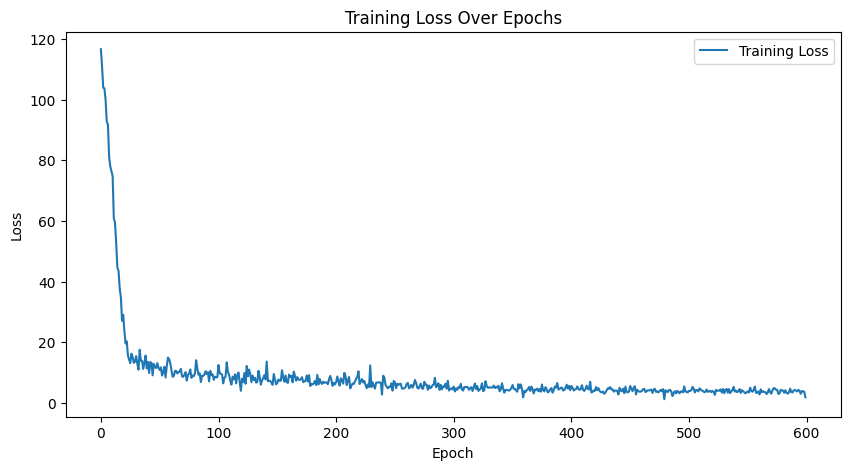

In [253]:
# plot the training loss    
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


152 600
[0, 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 303, 307, 311, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 367, 371, 375, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 434, 438, 442, 446, 450, 453, 457, 461, 465, 469, 473, 477, 481, 485, 489, 493, 497, 501, 505, 509, 513, 517, 521, 525, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596]
[20.884666991233825, 7.45388043721517, 5.252525002757708, 4.315067215760549, 3.838244072596232]
120


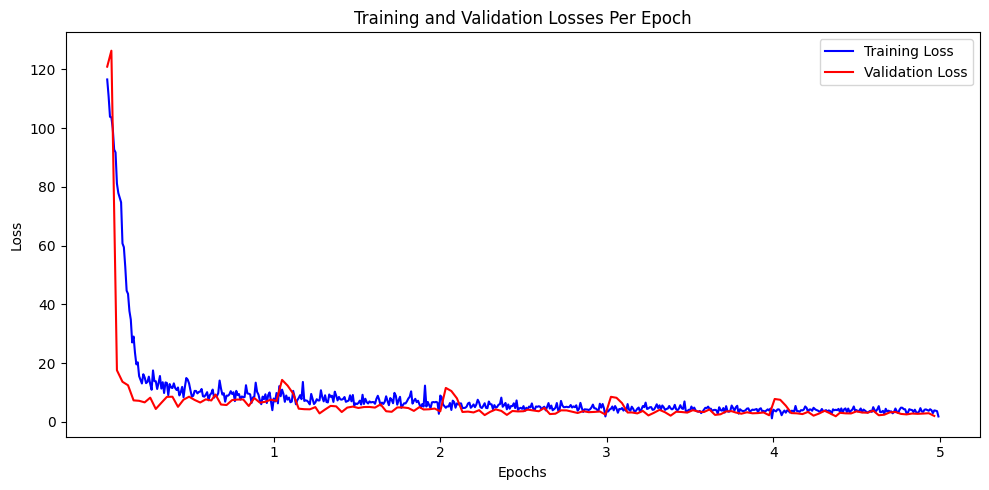

[116.58164978027344, 110.89232635498047, 103.87272644042969, 103.69490051269531, 99.92013549804688, 92.70875549316406, 91.73868560791016, 81.14977264404297, 77.92276000976562, 76.29220581054688, 74.74878692626953, 60.74714660644531, 59.46159362792969, 52.80885314941406, 44.65790557861328, 43.57329559326172, 37.74225616455078, 34.82405090332031, 27.040014266967773, 29.041030883789062, 23.597530364990234, 19.56719970703125, 20.26397705078125, 15.557611465454102, 14.302974700927734, 13.057747840881348, 16.217498779296875, 15.119011878967285, 13.18062686920166, 13.602422714233398, 15.39437484741211, 12.862317085266113, 10.927821159362793, 17.50563621520996, 13.841882705688477, 13.84074592590332, 11.189001083374023, 13.21837329864502, 15.602889060974121, 11.338647842407227, 13.497802734375, 9.821696281433105, 13.426193237304688, 13.237988471984863, 9.077667236328125, 12.866752624511719, 11.706751823425293, 11.506364822387695, 13.105539321899414, 11.503758430480957, 10.849082946777344, 11.70

In [254]:
# Plot training and validation losses per epoch
def plot_losses_per_epoch(train_losses, val_losses, num_epochs=5, log_scale=False):
    """ Plot training and validation losses per epoch."""
    ig, ax = plt.subplots(figsize=(10, 5))

    # Get the lengths of the training and validation losses
    len_val_losses = len(val_losses)
    len_train_losess = len(train_losses)
    range_train_loses = range(len_train_losess)

    # Get the range of validation losses
    range_val_loses = [x *len_train_losess // len_val_losses for x in range(len_val_losses) ]

    # Set the x-ticks
    tick_positions  = [(i + 1) * len_train_losess//5 for i in range(5)]
    tick_labels =  [str(i + 1) for i in range(num_epochs)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    ax.plot(range_train_loses,train_losses, label='Training Loss', color='b')
    ax.plot(range_val_loses, val_losses, label='Validation Loss', color='r')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Losses Per Epoch')
    ax.legend()

    
    if log_scale:
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_losses_per_epoch(train_module.train_losses, train_module.validation_losses)

print(train_module.train_losses[:-1])

152 600
[0, 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 303, 307, 311, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 367, 371, 375, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 434, 438, 442, 446, 450, 453, 457, 461, 465, 469, 473, 477, 481, 485, 489, 493, 497, 501, 505, 509, 513, 517, 521, 525, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596]
[1.2935841391483942, 1.0009399111072221, 1.0022792249917984, 0.9997756977876028, 0.9978229845563571]
120


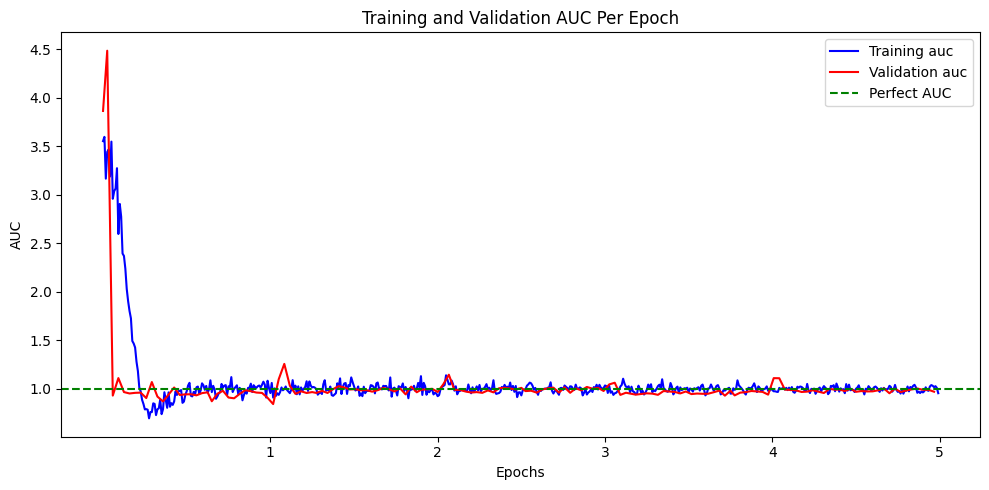

[3.5543859004974365, 3.598276376724243, 3.167407274246216, 3.443009376525879, 3.4675071239471436, 3.1892008781433105, 3.5490448474884033, 2.960035562515259, 3.0384674072265625, 3.0659425258636475, 3.275247097015381, 2.597060203552246, 2.9069106578826904, 2.7760910987854004, 2.395667791366577, 2.370776414871216, 2.2397074699401855, 2.0307061672210693, 1.903704285621643, 1.803216814994812, 1.7279731035232544, 1.4940822124481201, 1.4677889347076416, 1.4271284341812134, 1.2810883522033691, 1.1842719316482544, 1.015255331993103, 0.974361002445221, 0.8879041075706482, 0.8449451923370361, 0.7890456914901733, 0.7921193242073059, 0.7863406538963318, 0.6971830725669861, 0.7627419233322144, 0.7614290118217468, 0.8520297408103943, 0.8453977108001709, 0.7303743362426758, 0.7905460596084595, 0.800094485282898, 0.8900197148323059, 0.7404335737228394, 0.790109395980835, 0.9660934805870056, 0.8829390406608582, 0.8060006499290466, 0.9643499255180359, 0.8166819214820862, 0.8533791303634644, 0.83581966161

In [255]:
def plot_aucs(train_losses, val_losses, num_epochs=5, log_scale=False):
    """ Plot training and validation aucs per epoch."""
    ig, ax = plt.subplots(figsize=(10, 5))

    # Get the lengths of the training and validation losses
    len_val_losses = len(val_losses)
    len_train_losess = len(train_losses)
    range_train_loses = range(len_train_losess)

    # Get the range of validation losses
    range_val_loses = [x *len_train_losess // len_val_losses for x in range(len_val_losses) ]

    # Set the x-ticks
    tick_positions  = [(i + 1) * len_train_losess//5 for i in range(5)]
    tick_labels =  [str(i + 1) for i in range(num_epochs)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    ax.plot(range_train_loses,train_losses, label='Training aucs', color='b')
    ax.plot(range_val_loses, val_losses, label='Validation aucs', color='r')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('auc')
    ax.set_title('Training and Validation aucs Per Epoch')
    ax.legend()

    
    if log_scale:
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_aucs(train_module.train_auc, train_module.validation_auc)

print(train_module.train_auc[:-1]  )

152 600
[0, 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 303, 307, 311, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 367, 371, 375, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 434, 438, 442, 446, 450, 453, 457, 461, 465, 469, 473, 477, 481, 485, 489, 493, 497, 501, 505, 509, 513, 517, 521, 525, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596]
[59.85776610374451, 27.203006585439045, 22.616067298253377, 20.0418186823527, 18.598453267415366]
120


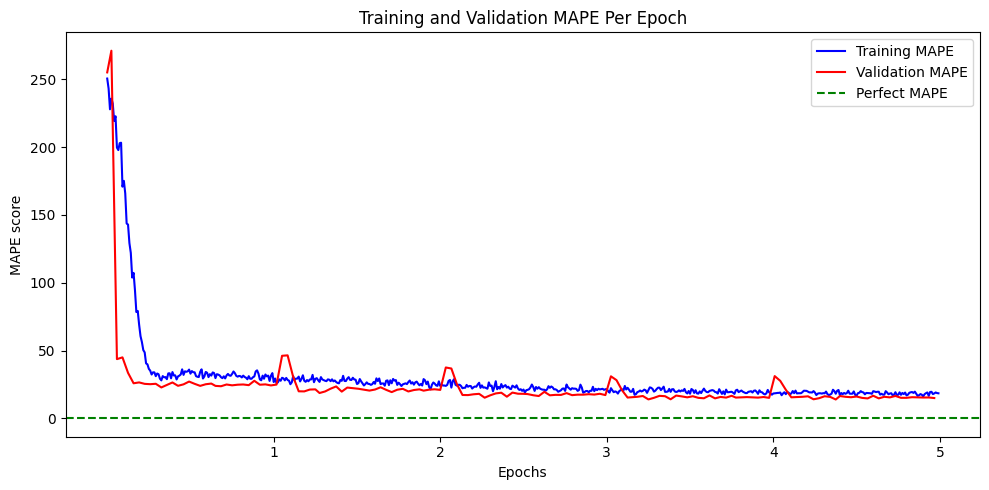

sdgsdgsd [250.65162658691406, 243.2848663330078, 227.9703826904297, 235.89952087402344, 232.21304321289062, 219.2809295654297, 222.813720703125, 199.69137573242188, 197.89300537109375, 202.9937744140625, 203.3212890625, 170.90335083007812, 175.1963653564453, 165.8634796142578, 143.7185821533203, 142.9569091796875, 129.257080078125, 122.0399398803711, 103.83538055419922, 107.31758117675781, 94.4914779663086, 78.42562866210938, 79.21256256103516, 69.03736877441406, 60.612022399902344, 56.255943298339844, 50.3641357421875, 48.63178634643555, 40.5456428527832, 39.805110931396484, 36.50082015991211, 35.15798568725586, 32.33829879760742, 33.939449310302734, 33.897552490234375, 31.114187240600586, 33.06739044189453, 32.54790115356445, 29.25870132446289, 28.00389289855957, 31.14861297607422, 30.256336212158203, 30.4111328125, 28.889387130737305, 33.155330657958984, 33.2177619934082, 29.525339126586914, 34.1422119140625, 31.630023956298828, 31.70395278930664, 28.692869186401367, 30.927572250366

In [256]:
def plot_MAPE(train_losses, val_losses, num_epochs=5, log_scale=False):
    """ Plot training and validation MAPE per epoch."""	
    fig, ax = plt.subplots(figsize=(10, 5))

    # Get the lengths of the training and validation losses
    len_val_losses = len(val_losses)
    len_train_losess = len(train_losses)
    range_train_loses = range(len_train_losess)

    # Get the range of validation losses
    range_val_loses = [x *len_train_losess // len_val_losses for x in range(len_val_losses) ]

    # Set the x-ticks
    tick_positions  = [(i + 1) * len_train_losess//5 for i in range(5)]
    tick_labels =  [str(i + 1) for i in range(num_epochs)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    ax.plot(range_train_loses,train_losses, label='Training MAPE', color='b')
    ax.plot(range_val_loses, val_losses, label='Validation MAPE', color='r')
    ax.axhline(y=0, color='g', linestyle='--', label='Perfect MAPE')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MAPE score')
    ax.set_title('Training and Validation MAPE Per Epoch')
    ax.legend()

    
    if log_scale:
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_MAPE(train_module.train_mape, train_module.val_mape)


#### Launch tensorboard for advanced training insights

In [257]:
# #Launch tensorboard for advanced training insights.
# os.system(f"taskkill /pid 19988 /F")

# # Reload the TensorBoard extension to avoid errors about it being already loaded
# %reload_ext tensorboard

# # Start TensorBoard
# % --logdir tb_logs/my_model

"""use code below in terminal to run tensorboard logger"""
#tensorboard--logdir tb_logs/my_model


## Test model

In [258]:
"""use code below to test model on testloaders"""
dataloaders = [test_synthetic_loader, test_measurement_loader]
trainer.test(train_module, dataloaders=dataloaders)

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Total L1 loss       │     55.08048629760742     │     89.70096588134766     │
│      Total auc_ratio      │    0.9849075675010681     │    1.0553433895111084     │
│      Total test_loss      │     2.911190986633301     │     7.809418678283691     │
│      test_mape_score      │    15.540801048278809     │    27.717927932739258     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'Total test_loss/dataloader_idx_0': 2.911190986633301,
  'Total L1 loss/dataloader_idx_0': 55.08048629760742,
  'Total auc_ratio/dataloader_idx_0': 0.9849075675010681,
  'test_mape_score/dataloader_idx_0': 15.540801048278809},
 {'Total test_loss/dataloader_idx_1': 7.809418678283691,
  'Total L1 loss/dataloader_idx_1': 89.70096588134766,
  'Total auc_ratio/dataloader_idx_1': 1.0553433895111084,
  'test_mape_score/dataloader_idx_1': 27.717927932739258}]

#### Test on Measurement data

In [3]:

trained_model = train_module
trained_model.eval()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(40, 20))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Measured Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_measurement_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

## test on synthetic data

In [4]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(40, 20))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Synthetic Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

### Test on mixed data

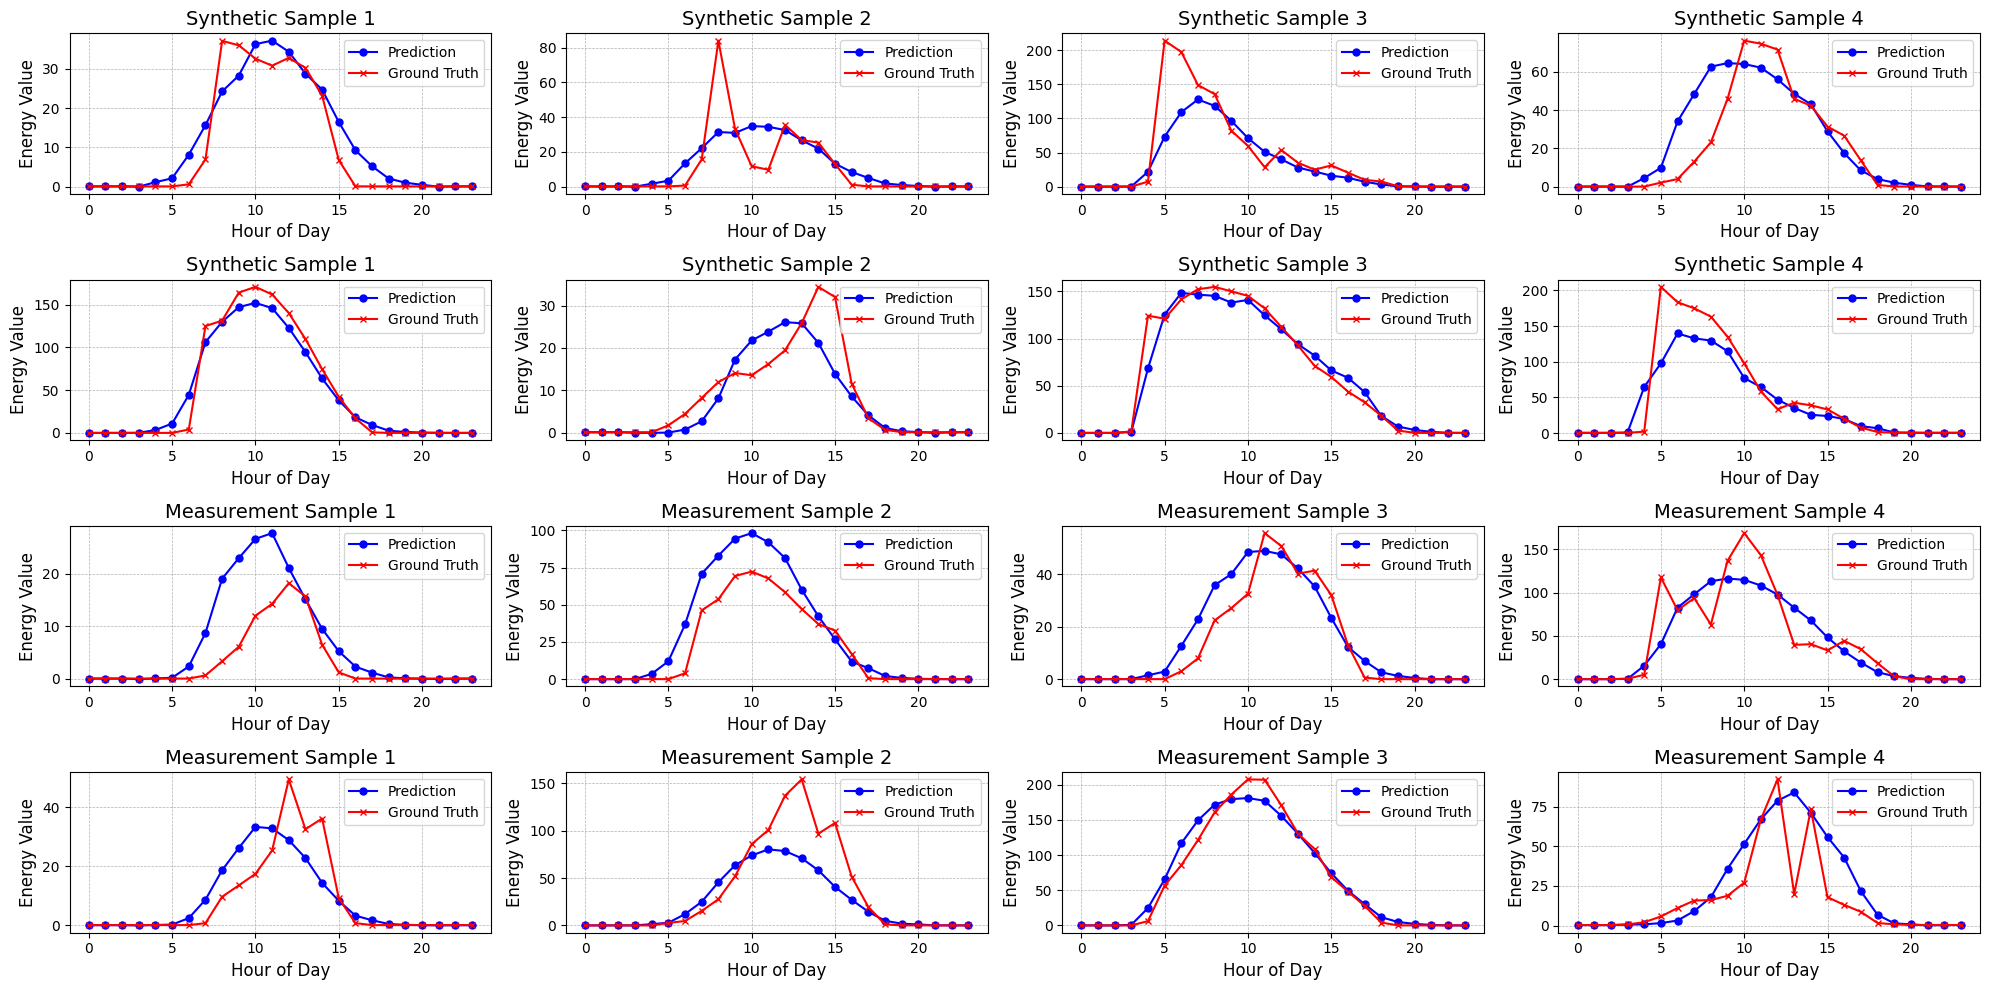

In [262]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        # Determine if the plot is for synthetic or measurement data
        if i < cols * 2:  # First two rows for synthetic data
            title_prefix = "Synthetic Sample"
        else:  # Last two rows for measurement data
            title_prefix = "Measurement Sample"

        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'{title_prefix} {i % cols + 1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot per category and subplots configuration
num_samples = 8  # Each category (synthetic, measurement) will have 4 samples
rows = 4
cols = 4

# Fetch samples from synthetic data loader
synthetic_dynamic, synthetic_static, synthetic_ground_truth = next(iter(test_synthetic_loader))
synthetic_dynamic = synthetic_dynamic[num_samples:]
synthetic_static = synthetic_static[num_samples:]
synthetic_ground_truth = synthetic_ground_truth[num_samples:]

# Fetch samples from measurement data loader
measurement_dynamic, measurement_static, measurement_ground_truth = next(iter(test_measurement_loader))
measurement_dynamic = measurement_dynamic[:num_samples]
measurement_static = measurement_static[:num_samples]
measurement_ground_truth = measurement_ground_truth[:num_samples]

# Predict using the synthetic samples
with torch.no_grad():
    synthetic_predictions = trained_model(synthetic_dynamic, synthetic_static)

# Predict using the measurement samples
with torch.no_grad():
    measurement_predictions = trained_model(measurement_dynamic, measurement_static)

# Combine predictions and ground truths
combined_predictions = torch.cat((synthetic_predictions, measurement_predictions))
combined_ground_truth = torch.cat((synthetic_ground_truth, measurement_ground_truth))

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples * 2, combined_predictions, combined_ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

## inference for Final model 

This seems more complex then it is. all data is normalized, but it is easier for the model to automatically process unnormalized data. Therefore this code first unnormalizes the data before passing it into the model. 

In [263]:
#save the model
torch.save(trained_model.model.state_dict(), 'final_models/energy_prediction_model.pth')

# Save the dataset values for inference
with open('final_models/dataset_values.pkl', 'wb') as f:
    pickle.dump(dataset_values, f)

In [264]:
# Load the dataset values
with open('final_models/dataset_values.pkl', 'rb') as f:
    dataset_values = pickle.load(f)

# Load the trained model
model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size,fc_size, dropout_rate=0.1,dataset_values=dataset_values)
model.load_state_dict(torch.load('final_models/energy_prediction_model.pth'))
model.eval()

# Predict using the sample data
predictions = model.predict(sample_dynamic, sample_static)

# Load sample data
num_samples = 5
samples_dynamic, samples_static, ground_truth = next(iter(test_measurement_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Ensure normalization and computation are done with tensors
mean_static = torch.tensor(dataset_values['mean'][:2] + [0], dtype=torch.float32) 
std_static = torch.tensor(dataset_values['std'][:2] + [1], dtype=torch.float32)    
mean_dynamic = torch.tensor(dataset_values['mean'][2:], dtype=torch.float32)
std_dynamic = torch.tensor(dataset_values['std'][2:], dtype=torch.float32)

# Apply normalization
samples_static = (samples_static * std_static ) + mean_static
samples_dynamic = (samples_dynamic * std_dynamic) + mean_dynamic



# Denormalize function using the dataset's method
def denormalize(data, dataset):
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Denormalize predictions and ground truth
predictions_denorm = predictions
ground_truth_denorm = denormalize(ground_truth.numpy(), dataset)

# Function to plot energy data
def plot_energy_data(predictions, ground_truth, num_samples=5):
    fig, axes = plt.subplots(1,AMOUNT_OF_SAMPLES, figsize=(num_samples * 5,5))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        axes[i].plot(predictions[i], label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        axes[i].plot(ground_truth[i], label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        axes[i].set_title(f'Sample {i+1}', fontsize=14)
        axes[i].set_xlabel('Hour of Day', fontsize=12)
        axes[i].set_ylabel('Energy Value', fontsize=12)
        axes[i].legend()
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the energy data for the specified number of samples
plot_energy_data(predictions_denorm, ground_truth_denorm, num_samples=AMOUNT_OF_SAMPLES)

2
input torch.Size([5, 24, 5]) torch.Size([5, 3])
dynamic cols value 5
shape x_static, x_dynamic torch.Size([5, 3]) torch.Size([5, 24, 5])
x_static_norm torch.Size([5, 3]) tensor([[-2.6222, -1.6580, -0.5209],
        [-2.7793, -1.6601, -0.5209],
        [-2.6783, -1.6944, -0.5209],
        [-2.6510, -1.6817, -0.5209],
        [-2.6060, -1.6676, -0.5209]])


C:\Users\denni\AppData\Local\Temp\ipykernel_24784\2900650543.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_static = torch.tensor(x_static, dtype=torch.float32)
C:\Users\denni\AppData\Local\Temp\ipykernel_24784\2900650543.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_dynamic = torch.tensor(x_dynamic, dtype=torch.float32)


RuntimeError: The size of tensor a (5) must match the size of tensor b (6) at non-singleton dimension 2

### Hyperparameter optimization 

In [ ]:
# import sys 
# sys.exit("Stopping the notebook execution here.")

# Assuming the create_data_loaders function is defined elsewhere
train_loader, val_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    synthetic_sampling_ratio=1,  # 100% of the synthetic dataset
    measured_split_ratio=0.6,    # 60% of the measured dataset for training
    synthetic_split_ratio=0.7,   # 70% of the synthetic dataset for training
    val_ratio=0.2,               # 10% of the training data for validation
    batch_size=64)  

def objective(trial, train_loader, val_loader):
    """ Objective function for the hyperparameter optimization."""
    # Define the hyperparameters search space
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical("hidden_size",[2,4,8,16,32,64])
    fc_size = trial.suggest_categorical("fc_size",[16,32,64,128,256,512])
    loss_type = trial.suggest_categorical("loss_type", ['mse', 'l1', 'huber'])

    # Instantiate the model with the suggested hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=5,  
        static_feature_size=3,  
        hidden_size=hidden_size,
        fc_size = fc_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
        dataset_values=dataset_values
    )
    
    # Set up the logger and checkpoint callback
    logger = CSVLogger("optuna_logs", name="energy_prediction")
    checkpoint_callback = ModelCheckpoint(
        dirpath="models2/",
        filename="best-model-{epoch:02d}-{val_evaluation_metric:.2f}",
        save_top_k=1,
        verbose=True,
        monitor='val_evaluation_metric',
        mode='min'
    )
    
    # Initialize the trainer
    trainer = Trainer(
        logger=logger,
        callbacks=[checkpoint_callback],
        max_epochs=5,     
    )
    # Fit the model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Use validation loss to determine the best model
    val_loss = trainer.callback_metrics.get("val_evaluation_metric", float('inf'))

    # # Store the best model path in the trial's user attributes
    best_model_path = checkpoint_callback.best_model_path

    # Save the best model path in the trial's user attributes
    if best_model_path: 
        trial.set_user_attr("best_model_path", best_model_path)

    else:
        raise ValueError("Model checkpoint path is empty!")
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train_loader, val_loader), n_trials=100, timeout=7200)  # Run for 100 trials or 2 hour


print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print("Best model saved to:", trial.user_attrs.get('best_model_path', 'Not available'))
    
print("Best model saved to:", trial.user_attrs['best_model_path'])

[I 2024-06-10 15:14:09,727] A new study created in memory with name: no-name-08d0be70-b595-4476-a8ba-40aeccf64a60
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 543 K 
1 | loss_fn | MSELoss               | 0     
--------------------------------------------------
543 K     Trainable params
0         Non-trainable params
543 K     Total params
2.173     Total estimated model params size (MB)


size of the total dataset: 13839 
size of synthetic data: 12497 = 0.90
size of the measured data: 1342 = 0.10

size of the total dataset after subsampling: 13839 
 Size of synthetic data: 12497 = 0.90 
 Size of the measured data: 1342 = 0.10 
 ________________________________________________________

Training set size (synthetic): 6998 = 0.56 of synthetic data
Training set size (measured): 644 = 0.48 of measured data 

Validation set size (synthetic): 1749 = 0.14 of synthetic data
Validation set size (measured): 161 = 0.12 of measured data 

Test set size (synthetic): 3750 = 0.30 of synthetic data
Test set size (measured): 537 = 0.40 of measured data 



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.05725 (best 0.05725), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.06.ckpt' as top 1
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
[I 2024-06-10 15:14:22,828] Trial 0 finished with value: 0.057249147444963455 and parameters: {'learning_rate': 0.002767493830834293, 'hidden_size': 2, 'fc_size': 512, 'loss_type': 'mse'}. Best is trial 0 with value: 0.057249147444963455.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdiscipli

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.07698 (best 0.07698), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.08.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.06574 (best 0.06574), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.06024 (best 0.06024), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.05687 (best 0.05687), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.05391 (best 0.05391), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.05-v7.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:15:16,434] Trial 1 finished with value: 0.05390807241201401 and parameters: {'learning_rate': 0.0004919166596322929, 'hidden_size': 32, 'fc_size': 32, 'loss_type': 'mse'}. Best is trial 1 with value: 0.05390807241201401.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.04582 (best 0.04582), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.04035 (best 0.04035), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.03854 (best 0.03854), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.04-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03758 (best 0.03758), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.04-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.03741 (best 0.03741), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.04-v6.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:16:10,288] Trial 2 finished with value: 0.03740621358156204 and parameters: {'learning_rate': 0.03340913070340877, 'hidden_size': 16, 'fc_size': 32, 'loss_type': 'huber'}. Best is trial 2 with value: 0.03740621358156204.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.36690 (best 0.36690), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.37.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.36071 (best 0.36071), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.36.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.35405 (best 0.35405), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.34629 (best 0.34629), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.33698 (best 0.33698), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.34.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:17:49,698] Trial 3 finished with value: 0.33698123693466187 and parameters: {'learning_rate': 1.6610869571231937e-05, 'hidden_size': 2, 'fc_size': 64, 'loss_type': 'mse'}. Best is trial 2 with value: 0.03740621358156204.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.04853 (best 0.04853), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.03603 (best 0.03603), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.03447 (best 0.03447), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03415 (best 0.03415), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.03-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.03251 (best 0.03251), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.03-v36.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:19:47,468] Trial 4 finished with value: 0.03251497447490692 and parameters: {'learning_rate': 0.015005897883653203, 'hidden_size': 8, 'fc_size': 512, 'loss_type': 'mse'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.12106 (best 0.12106), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.07612 (best 0.07612), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.08.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.06887 (best 0.06887), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.06606 (best 0.06606), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.06397 (best 0.06397), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.06-v4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:21:38,739] Trial 5 finished with value: 0.06397360563278198 and parameters: {'learning_rate': 0.000121200726790845, 'hidden_size': 4, 'fc_size': 256, 'loss_type': 'huber'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Nam

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.08934 (best 0.08934), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.07249 (best 0.07249), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.06568 (best 0.06568), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.06316 (best 0.06316), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.05610 (best 0.05610), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.06-v5.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:23:31,596] Trial 6 finished with value: 0.05609649792313576 and parameters: {'learning_rate': 0.0007413856420557118, 'hidden_size': 4, 'fc_size': 32, 'loss_type': 'mse'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.06691 (best 0.06691), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.05586 (best 0.05586), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.04725 (best 0.04725), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.04345 (best 0.04345), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.04-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.04069 (best 0.04069), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.04-v7.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:25:26,652] Trial 7 finished with value: 0.04069497436285019 and parameters: {'learning_rate': 0.0005756296505079428, 'hidden_size': 16, 'fc_size': 128, 'loss_type': 'mse'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Nam

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.06659 (best 0.06659), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.05644 (best 0.05644), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.04912 (best 0.04912), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.04508 (best 0.04508), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.04096 (best 0.04096), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.04-v8.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:40:12,629] Trial 8 finished with value: 0.040959328413009644 and parameters: {'learning_rate': 0.0010676715619389347, 'hidden_size': 64, 'fc_size': 16, 'loss_type': 'l1'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.06575 (best 0.06575), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.05878 (best 0.05878), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.05681 (best 0.05681), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.05053 (best 0.05053), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.04429 (best 0.04429), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.04-v9.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:41:18,871] Trial 9 finished with value: 0.04429030790925026 and parameters: {'learning_rate': 0.0010850123149824063, 'hidden_size': 4, 'fc_size': 256, 'loss_type': 'mse'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.13978 (best 0.13978), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.14-v6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:43:13,094] Trial 10 finished with value: 0.13978147506713867 and parameters: {'learning_rate': 0.07704942231114174, 'hidden_size': 8, 'fc_size': 512, 'loss_type': 'l1'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 4.1 K 
1 | loss_fn | HuberLoss             | 0     
----------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.04982 (best 0.04982), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.04140 (best 0.04140), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03927 (best 0.03927), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.04-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
[I 2024-06-10 15:45:02,974] Trial 11 finished with value: 0.03926924988627434 and parameters: {'learning_rate': 0.04379484814598522, 'hidden_size': 8, 'fc_size': 32, 'loss_type': 'huber'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 559 K 
1 | loss_fn | HuberLoss             | 0     
------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.03979 (best 0.03979), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.03352 (best 0.03352), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.03205 (best 0.03205), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03069 (best 0.03069), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.03-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.03034 (best 0.03034), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.03-v37.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:46:55,560] Trial 12 finished with value: 0.030336281284689903 and parameters: {'learning_rate': 0.01470966307496129, 'hidden_size': 16, 'fc_size': 512, 'loss_type': 'huber'}. Best is trial 12 with value: 0.030336281284689903.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.04222 (best 0.04222), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.03805 (best 0.03805), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.03445 (best 0.03445), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03261 (best 0.03261), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.03-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.03008 (best 0.03008), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.03-v38.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:48:47,019] Trial 13 finished with value: 0.030080202966928482 and parameters: {'learning_rate': 0.010099682923878054, 'hidden_size': 8, 'fc_size': 512, 'loss_type': 'huber'}. Best is trial 13 with value: 0.030080202966928482.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.04157 (best 0.04157), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.03680 (best 0.03680), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.03387 (best 0.03387), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03067 (best 0.03067), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.03-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.02934 (best 0.02934), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.03-v39.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:50:39,881] Trial 14 finished with value: 0.029338985681533813 and parameters: {'learning_rate': 0.007621325902448184, 'hidden_size': 16, 'fc_size': 512, 'loss_type': 'huber'}. Best is trial 14 with value: 0.029338985681533813.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.04054 (best 0.04054), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.03881 (best 0.03881), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.03468 (best 0.03468), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03089 (best 0.03089), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.03-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.02964 (best 0.02964), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.03-v40.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:52:31,678] Trial 15 finished with value: 0.029635395854711533 and parameters: {'learning_rate': 0.00477305049123279, 'hidden_size': 32, 'fc_size': 512, 'loss_type': 'huber'}. Best is trial 14 with value: 0.029338985681533813.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.05171 (best 0.05171), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.04399 (best 0.04399), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
[I 2024-06-10 16:25:22,751] Trial 16 finished with value: 0.04398880898952484 and parameters: {'learning_rate': 0.004710937191443452, 'hidden_size': 32, 'fc_size': 16, 'loss_type': 'huber'}. Best is trial 14 with value: 0.029338985681533813.


Best trial:
  Value:  0.029338985681533813
  Params: 
    learning_rate: 0.007621325902448184
    hidden_size: 16
    fc_size: 512
    loss_type: huber
Best model saved to: C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2\best-model-epoch=04-val_evaluation_metric=0.03-v39.ckpt
Best model saved to: C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2\best-model-epoch=04-val_evaluation_metric=0.03-v39.ckpt


Analyze the hyperparameter optimization and get the best available study. The code below allows to automatically plot results of the best model found

In [ ]:

final_losses = [trial.value for trial in study.trials if trial.value is not None]

# Print the losses
for i, loss in enumerate(final_losses):
    print(f"Trial {i}: Loss = {loss}")

print(study.best_trial)
print(study.best_params)

Trial 0: Loss = 0.03403798118233681
Trial 1: Loss = 0.05090358853340149
Trial 2: Loss = 0.052484095096588135
Trial 3: Loss = 0.053935013711452484
Trial 4: Loss = 0.026293646544218063
Trial 5: Loss = 0.05471372604370117
Trial 6: Loss = 0.055354539304971695
Trial 7: Loss = 0.03514223173260689
Trial 8: Loss = 0.029653077945113182
Trial 9: Loss = 0.05209791287779808
Trial 10: Loss = 0.13924981653690338
Trial 11: Loss = 0.028374018147587776
Trial 12: Loss = 0.18188922107219696
Trial 13: Loss = 0.03307473286986351
Trial 14: Loss = 0.039569489657878876
Trial 15: Loss = 0.03947662562131882
Trial 16: Loss = 0.031904444098472595
Trial 17: Loss = 0.03226937726140022
Trial 18: Loss = 0.0356057770550251
Trial 19: Loss = 0.13924981653690338
Trial 20: Loss = 0.0326620452105999
Trial 21: Loss = 0.03022455796599388
Trial 22: Loss = 0.02991694025695324
Trial 23: Loss = 0.13924981653690338
Trial 24: Loss = 0.03533296659588814
Trial 25: Loss = 0.031364716589450836
Trial 26: Loss = 0.0420178547501564
Trial

In [ ]:
def save_hyperparameters(trial, filename="hyperparameters.txt"):
    """ Save the hyperparameters of the best trial to a file."""	
    with open(filename, "w") as f:
        for key, value in trial.params.items():
            f.write(f"{key}: {value}\n")
            print(f"{key}: {value}")

def load_model(checkpoint_path, trial):
    """ Load the model from the checkpoint and return it."""
    # Extract hyperparameters from the trial
    learning_rate = trial.params['learning_rate']
    hidden_size = trial.params['hidden_size']
    fc_size = trial.params['fc_size']
    loss_type = trial.params['loss_type']    

    # Instantiate the model with the trial's hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=5,  
        static_feature_size=3,  
        hidden_size=hidden_size,
        fc_size =fc_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
        dataset_values=dataset_values
    )
    
    # Load the model's weights from the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

def evaluate_model(model, test_loader):
    """ Evaluate the model on the test set."""	
    trainer = Trainer(logger=False)
    results = trainer.test(model, dataloaders=test_loader)
    return results

# Retrieve the best trial
best_trial = study.best_trial
print(best_trial)

# Print all user attributes to debug
print("User attributes of the best trial:", best_trial.user_attrs)

# Check if 'best_model_path' is present
if 'best_model_path' in best_trial.user_attrs:
    checkpoint_path = best_trial.user_attrs['best_model_path']

    # Load the best model
    model = load_model(checkpoint_path, best_trial)
    torch.save(model.state_dict(), f"{checkpoint_path}.pth")
    save_hyperparameters(trial, filename=f"{checkpoint_path}_hyperparams.txt")

    print(f"Evaluating best model from trial {best_trial.number}")

    # Evaluate on both synthetic and measurement test loaders
    model_results = evaluate_model(model, [test_synthetic_loader,test_measurement_loader])
    print("Results for the best model:")
    print("Synthetic Test Set:", model_results)
    
else:
    print("Best model path not found in the best trial's user attributes.")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FrozenTrial(number=40, state=1, values=[0.026280932128429413], datetime_start=datetime.datetime(2024, 6, 10, 14, 33, 23, 593175), datetime_complete=datetime.datetime(2024, 6, 10, 14, 34, 19, 769884), params={'learning_rate': 0.005387181130426583, 'hidden_size': 32, 'fc_size': 512, 'loss_type': 'l1'}, user_attrs={'best_model_path': 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.03-v20.ckpt'}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'hidden_size': CategoricalDistribution(choices=(2, 4, 8, 16, 32, 64)), 'fc_size': CategoricalDistribution(choices=(16, 32, 64, 128, 256, 512)), 'loss_type': CategoricalDistribution(choices=('mse', 'l1', 'huber'))}, trial_id=40, value=None)
User attributes of the best trial: {'best_model_path': 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdiscipli

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Total L1 loss       │     37.85572814941406     │     68.50373840332031     │
│      Total auc_ratio      │    1.0041295289993286     │    0.8254183530807495     │
│      Total test_loss      │     37.85572814941406     │     68.50373840332031     │
│       test_r2_score       │    0.9128523468971252     │    0.6213898062705994     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

Results for the best model:
Synthetic Test Set: [{'Total test_loss/dataloader_idx_0': 37.85572814941406, 'Total L1 loss/dataloader_idx_0': 37.85572814941406, 'Total auc_ratio/dataloader_idx_0': 1.0041295289993286, 'test_r2_score/dataloader_idx_0': 0.9128523468971252}, {'Total test_loss/dataloader_idx_1': 68.50373840332031, 'Total L1 loss/dataloader_idx_1': 68.50373840332031, 'Total auc_ratio/dataloader_idx_1': 0.8254183530807495, 'test_r2_score/dataloader_idx_1': 0.6213898062705994}]


The function below can be used to visually inspect the results of the best hyperparameter optimalization.

In [ ]:
# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = model.predict(samples_dynamic, samples_static)

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

AttributeError: 'TrainEnergyPrediction' object has no attribute 'predict'